In [53]:
import subprocess
from rpy2.robjects import r
from rc_data_class import RcData
from rc_folds_class  import rcFolds
from rc_pred_ann_model import PredAnnModel
from rc_individual_fold import RcFoldForANN
import numpy as np
import random
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle

# Genetic Algorithm Parameters
POP_SIZE = 50        # Population size
N_GENERATIONS = 50   # Number of generations
TOURNAMENT_SIZE = 3  # Tournament selection (k=3)
CROSSOVER_RATE = 0.8 # Probability of crossover
MUTATION_RATE = 0.01 # Mutation probability per gene
ELITE_PERCENTAGE = 0.05 # Top 5% preserved

#Other parameters
p_value = 0.1
split_train = True
folds = 5
num_epochs = 500
dna_dict = {}  # Empty dictionary

# making a data frame to keep track of GA progress
column_names = [f'auc_{i+1}' for i in range(POP_SIZE)]
# Initialize an empty DataFrame with columns
ga_df = pd.DataFrame(columns=column_names)


def get_genes_list(p_thresh, split_train):
    # Define the R script path
    r_script = "rc_get_diff_genes.r"
    
    # Build the command to run the R script
    command = ["Rscript", r_script, str(p_thresh), str(split_train)]
    
    result = subprocess.run(command, capture_output=True, text=True)
    
    # Check if the R script ran successfully
    if result.returncode == 0:
        print("R script executed successfully.")
    
        # Read the generated file
        rds_path = '/tmp/work/RCproject_code/sean_ann_python/ann_gene_set.rds'
        current_genes = r.readRDS(rds_path)
        print(len(current_genes))
        
    else:
        print("Error in R script execution:")
        print(result.stderr)

    return(current_genes.tolist())

def generate_individual():
    """Creates a binary chromosome for feature selection."""
    return [random.randint(0, 1) for _ in range(len(current_genes))]

def evaluate_fitness(individual,gene_list,input_data,count):
    """Evaluates the fitness of an individual based on the average test auc value across folds."""
    selected_features = [s for s, m in zip(gene_list, individual) if m]  #application of a binary mask to the genes list
    if len(selected_features) == 0:
        return 0  # Prevent division by zero when no features are selected
    current_aucs = []
    current_folds = rcFolds(input_data,folds)
    for i in range(folds):
            current_fold = RcFoldForANN(current_folds,i)
            fold_count = i + 1
            current_member = count + 1
            print(f"Currently training, population member {current_member}, with fold {fold_count}.")
            current_model = PredAnnModel(current_fold,current_genes, num_epochs = num_epochs)
            test_auc_list = current_model.test_auc_list
            current_auc = max(test_auc_list)
            current_aucs.append(current_auc)
    score = np.mean(current_aucs)
    return score  # Higher auc average = better fitness

def tournament_selection(population, fitness_scores):
    """Selects a parent using tournament selection (k=3)."""
    competitors = random.sample(list(enumerate(fitness_scores)), TOURNAMENT_SIZE)
    best = max(competitors, key=lambda x: x[1])  # Select individual with best fitness
    return population[best[0]]


def uniform_crossover(parent1, parent2):
    """Performs uniform crossover (each gene has 50% chance of swapping)."""
    if random.random() < CROSSOVER_RATE:
        child1 = [p1 if random.random() > 0.5 else p2 for p1, p2 in zip(parent1, parent2)]
        child2 = [p2 if random.random() > 0.5 else p1 for p1, p2 in zip(parent1, parent2)]
        return child1, child2
    return parent1[:], parent2[:]  # No crossover, children are copies

def mutate(individual):
    """Mutates an individual by flipping bits with a small probability."""
    return [1 - gene if random.random() < MUTATION_RATE else gene for gene in individual]

def plot_row_averages(df):
    """
    Plots the average of each row in the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing numerical values.
    """
    row_averages = df.mean(axis=1)  # Compute the average across each row
    
    plt.figure(figsize=(10, 5))
    plt.plot(row_averages, marker='o', linestyle='-', color='b', label='Row Averages')
    
    plt.xlabel("Generation")
    plt.ylabel("Average AUC Values")
    plt.title("Average of Each Row in DataFrame")
    plt.legend()
    plt.grid(True)
    
    plt.show()


# establish the dataset object
current_data = RcData()

# grab the intial feature set
current_genes = get_genes_list(p_value, split_train)

# making a data frame to keep track of GA progress
column_names = [f'auc_{i+1}' for i in range(POP_SIZE)]

# Initialize an empty DataFrame with columns
ga_df = pd.DataFrame(columns=column_names)

# Initialize population
population = [generate_individual() for _ in range(POP_SIZE)]
dna_dict[1] = population

# Evaluate initial fitness

fitness_scores = [evaluate_fitness(ind, current_genes, current_data, count) for count, ind in enumerate(population)]

best_fitness = max(fitness_scores)
print(f"Generation {1}, Best Accuracy: {best_fitness:.4f}")

ga_df.loc[len(ga_df)] = fitness_scores

for gen in range(N_GENERATIONS):
    # Select the top individuals (elitism)
    elite_count = int(ELITE_PERCENTAGE * POP_SIZE)
    elites = [population[i] for i in np.argsort(fitness_scores)[-elite_count:]]  # Keep best individuals

    # Generate next generation
    new_population = elites[:]  # Start with elites

    while len(new_population) < POP_SIZE:
        # Select parents using tournament selection
        parent1 = tournament_selection(population, fitness_scores)
        parent2 = tournament_selection(population, fitness_scores)

        # Crossover to generate children
        child1, child2 = uniform_crossover(parent1, parent2)

        # Apply mutation
        child1 = mutate(child1)
        child2 = mutate(child2)

        # Add to new population (ensure we don't exceed population size)
        new_population.append(child1)
        if len(new_population) < POP_SIZE:
            new_population.append(child2)

    # Update population and fitness scores
    population = new_population
    current_generation = gen + 2
    dna_dict[current_generation] = new_population
    fitness_scores = [evaluate_fitness(ind, current_genes, current_data, count) for count, ind in enumerate(population)]
    ga_df.loc[len(ga_df)] = fitness_scores

    pickle.dump(dna_dict, open("dna_dict.pkl", "wb"))
    ga_df.to_pickle("ga_df.pkl")

    # Print best result every 10 generations
    if gen % 1 == 0:
        best_fitness = max(fitness_scores)
        print(f"Generation {current_generation}, Best Accuracy: {best_fitness:.4f}")

Data successfully loaded.
R script executed successfully.
910
Currently training, population member 1, with fold 1.
Epoch 0, Average Outcome Loss: 0.6920267409748502, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3378
Currently training, population member 1, with fold 2.
Epoch 0, Average Outcome Loss: 0.7173478205998739, Average Accuracy: 0.4652777777777778, Test AUC: 0.5000, Test Accuracy: 0.6486
Currently training, population member 1, with fold 3.
Epoch 0, Average Outcome Loss: 0.8478866550657485, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.6486
Currently training, population member 1, with fold 4.
Epoch 0, Average Outcome Loss: 0.7368887265523275, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.3514
Currently training, population member 1, with fold 5.
Epoch 0, Average Outcome Loss: 0.6959017912546793, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.6575
Currently training, population member 2, with fold 1.
Epoch 0, Average Outcome Loss

In [54]:
# Load the df back
loaded_df = pd.read_pickle("ga_df.pkl")
# Load the dictionary to select the sequences of interest
dna_dict = pickle.load(open("dna_dict.pkl", "rb"))

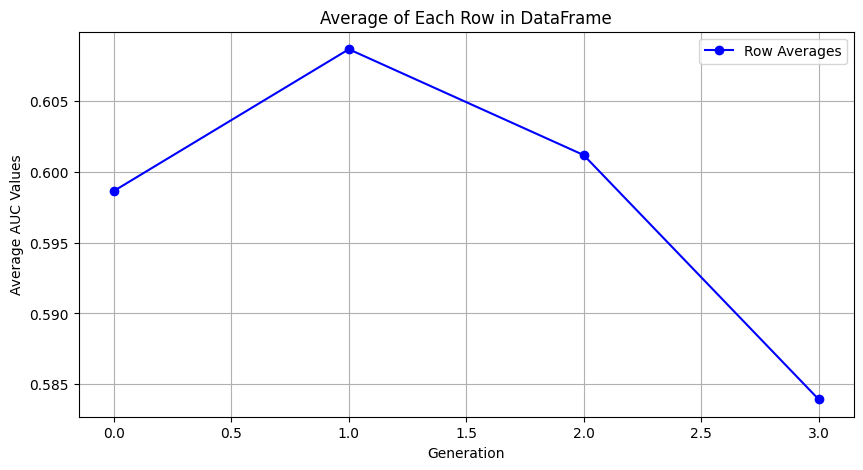

In [55]:
plot_row_averages(loaded_df)